## Estimating the time with exposition to satellites


We perform this test for SKA-Low with the population of starlink as of March 2025, and an effective beam that includes the first side lobe.


### 1. Imports
We start by importing standard libraries and the needed functions from `analytical_satsky`

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u

from analytical_satsky.model import simulate_exposed_time, compute_exposure_fraction, correct_for_ra

from matplotlib.colors import LogNorm
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 2. Shells
We then load the shells of interest.

In [2]:
from analytical_satsky.loaders import load_table_starlink_march25

shells_df = load_table_starlink_march25()
print(shells_df)

           i           h     n
0  43.002045  502.730350  2575
1  53.151458  350.573937   439
2  53.151458  466.106828  1021
3  53.151458  542.588082  2383
4  70.000195  552.705926   432
5  97.655455  557.949260   231


### 3. Run model
Should take about 10 s.

In [3]:
skamid_lat = (-26.7033194*u.deg).to(u.rad)
skamid_lon = (116.67081524*u.deg).to(u.rad)
obsheight = 337 * u.m
Lfov = 17.8*u.deg
texp = 3600*u.s
target_decs = np.arange(10, -80, -5)*u.deg
target_ra = np.array([0])*u.deg
ntimestep = int(texp.to(u.s).value * 5)

fractions_q16 = np.zeros_like(target_decs.value)
fractions_q5   = np.zeros_like(target_decs.value)
fractions_q84 = np.zeros_like(target_decs.value)
for i in range(len(target_decs)):
    target_dec = target_decs[[i]]
    target_ra = correct_for_ra(skamid_lat, skamid_lon, obsheight, target_dec, target_ra, nsteps=360)
    all_inits, all_ts = simulate_exposed_time(shells_df, Lfov, skamid_lat, skamid_lon, target_dec, target_ra, texp, nstat=100)
    fractions = compute_exposure_fraction(texp, ntimestep, all_inits, all_ts)
    fractions_q16[i] = np.quantile(fractions, 0.16)
    fractions_q5[i] = np.quantile(fractions, 0.5)
    fractions_q84[i] = np.quantile(fractions, 0.84)

### 4. Plot 
We can finally plot the data. This reproduces the points shown in figure B.1 in the letter.

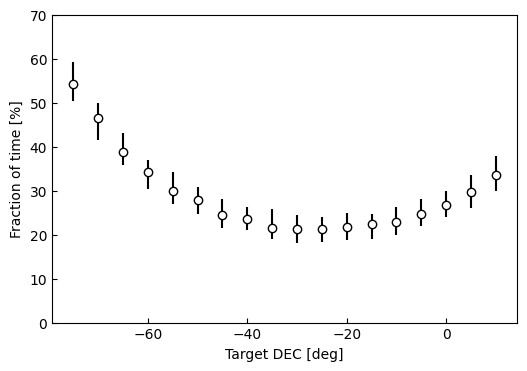

In [4]:
figure(figsize=(6,4))
errorbar(target_decs, fractions_q5*100, yerr=[(fractions_q5-fractions_q16)*100, (fractions_q84-fractions_q5)*100], 
         fmt='o', c='k', capsize=0.0, label="Analytical", markerfacecolor='w')
xlabel(r'Target DEC [deg]')
ylabel(r'Fraction of time [%]')
ylim([0,70])
tick_params('both', colors='k', direction='in', which='both')